<a href="https://colab.research.google.com/github/tocom242242/anomaly-detection-using-simple-autoencoder/blob/main/anomaly_detection_using_autoencoder_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import copy

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, losses, optimizers
from tensorflow.keras.models import Model

In [ ]:
def plot_imgs(input_imgs):
    plt.figure(figsize=(10,10))
    plt_idx = 1
    for i in range(36):
        plt.subplot(6,6,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(np.squeeze(input_imgs[i]), cmap="gray", vmin=0, vmax=1)
    plt.show()

In [ ]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
normal_idx = 1
abnormal_idx = 0

In [ ]:
x_normal_train = x_train[np.where(y_train==normal_idx)]
x_normal_test = x_test[np.where(y_test==normal_idx)]

In [ ]:
x_abnormal_train = x_train[np.where(y_train==abnormal_idx)]
x_abnormal_test = x_test[np.where(y_test==abnormal_idx)]
x_abnormal = np.concatenate((x_abnormal_train,x_abnormal_test))

## normal data

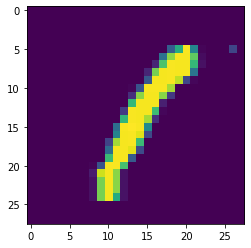

In [ ]:
plt.imshow(x_normal_train[80])

## abnormal data

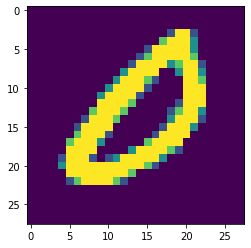

In [ ]:
plt.imshow(x_abnormal_train[80])

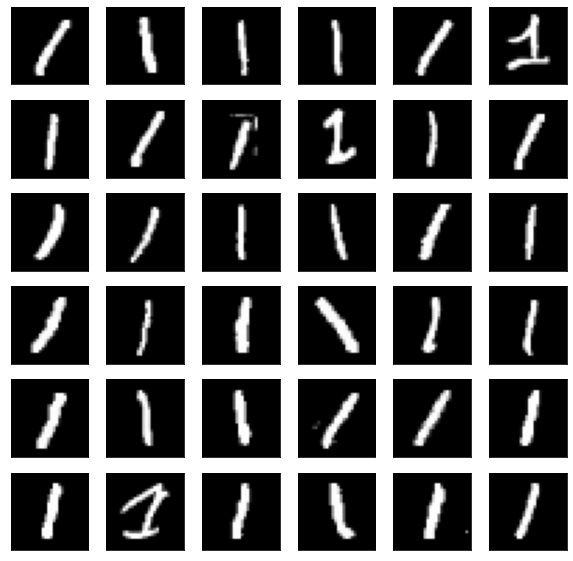

In [ ]:
plot_imgs(x_normal_train)

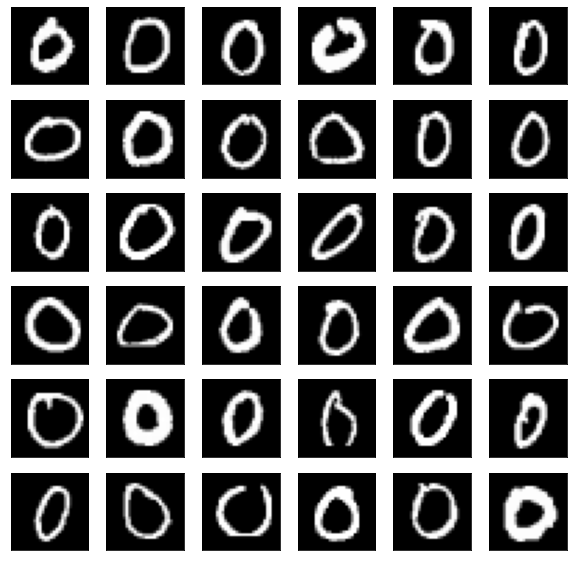

In [ ]:
plot_imgs(x_abnormal_test)

In [ ]:
latent_dim = 32

# encoder
inputs = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(128, 3,  strides=1, padding="same",activation="relu")(inputs)
x = layers.Conv2D(64, 3,  strides=1, padding="same", activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(latent_dim)(x)

# decoder
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dense(7 * 7 * 64, activation="relu")(x)

x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)

outputs = layers.Conv2DTranspose(1, 3, strides=1,activation="sigmoid", padding="same")(x)


# create model
model = Model(inputs, outputs)
print(model.summary())
model.compile(optimizer=optimizers.Adam(), loss="binary_crossentropy")


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 128)       1280      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        73792     
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 1024)              51381248  
                                                                 
 dense_1 (Dense)             (None, 64)                65600     
                                                                 
 dense_2 (Dense)             (None, 32)                2080  

In [ ]:
x_normal_train = np.expand_dims(x_normal_train, axis=-1)
x_train, x_val = train_test_split(x_normal_train,train_size=0.9)

/content/drive/MyDrive/colab/checkpoint
Epoch 1/30
190/190 [==============================] - ETA: 0s - loss: 0.1229
Epoch 1: val_loss improved from inf to 0.06748, saving model to /content/drive/MyDrive/colab/checkpoint
190/190 [==============================] - 18s 38ms/step - loss: 0.1229 - val_loss: 0.0675
Epoch 2/30
190/190 [==============================] - ETA: 0s - loss: 0.0584
Epoch 2: val_loss improved from 0.06748 to 0.05459, saving model to /content/drive/MyDrive/colab/checkpoint
190/190 [==============================] - 6s 34ms/step - loss: 0.0584 - val_loss: 0.0546
Epoch 3/30
188/190 [============================>.] - ETA: 0s - loss: 0.0491
Epoch 3: val_loss improved from 0.05459 to 0.04691, saving model to /content/drive/MyDrive/colab/checkpoint
190/190 [==============================] - 7s 38ms/step - loss: 0.0490 - val_loss: 0.0469
Epoch 4/30
189/190 [============================>.] - ETA: 0s - loss: 0.0459
Epoch 4: val_loss improved from 0.04691 to 0.04660, saving mo

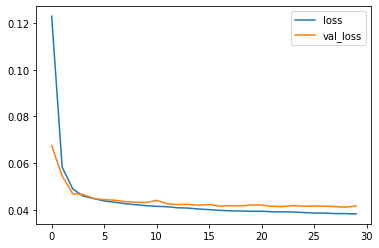

In [ ]:

MODEL_DIR = "/content/drive/MyDrive/colab/"

checkpoint_filepath = os.path.join(MODEL_DIR,'checkpoint')
print(checkpoint_filepath)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_best_only=True)

history = model.fit(x_train,x_train, epochs=30, shuffle=True, validation_data=(x_val, x_val), callbacks=[model_checkpoint_callback])
plt.plot(np.arange(len(history.history["loss"])),history.history["loss"], label="loss")
plt.plot(np.arange(len(history.history["val_loss"])),history.history["val_loss"], label="val_loss")
plt.legend()

model.load_weights(checkpoint_filepath)

In [ ]:
def plot_input_output(input_imgs):
    plt.figure(figsize=(10,10))
    plt_idx = 1
    for i in range(36):
        if plt_idx > 36:
            break
        plt.subplot(6,6,plt_idx)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(np.squeeze(input_imgs[i]), cmap="gray", vmin=0, vmax=1)
        plt.xlabel("input_{}".format(i))


        plt.subplot(6,6,plt_idx+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        
        output = model.predict(tf.expand_dims(input_imgs[i],axis=0))
        plt.imshow(np.squeeze(output), cmap="gray", vmin=0, vmax=1)
        plt.xlabel("output_{}".format(i))
        plt_idx+=2
    plt.show()

normal x_test's result


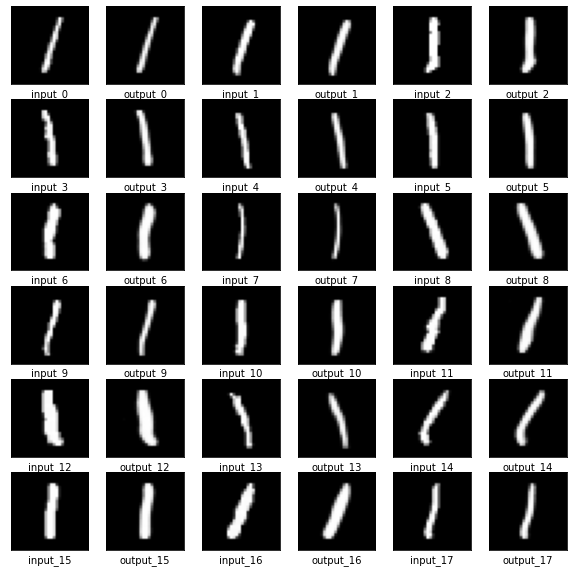

In [ ]:
print("normal x_test's result")
plot_input_output(x_normal_test)

abnormal x_test's result


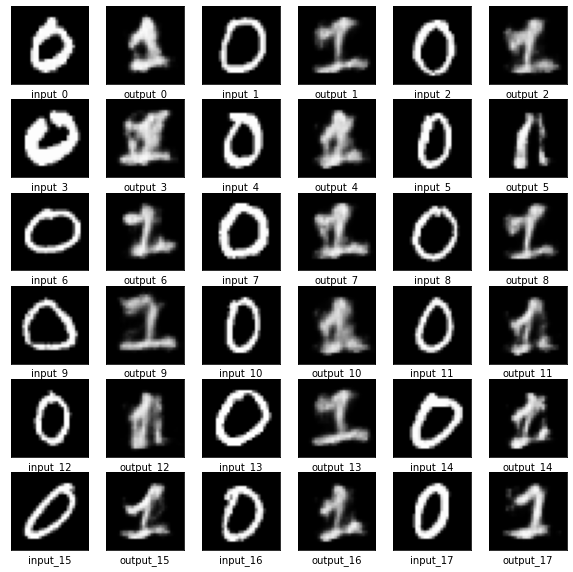

In [ ]:
print("abnormal x_test's result")
plot_input_output(x_abnormal_test)

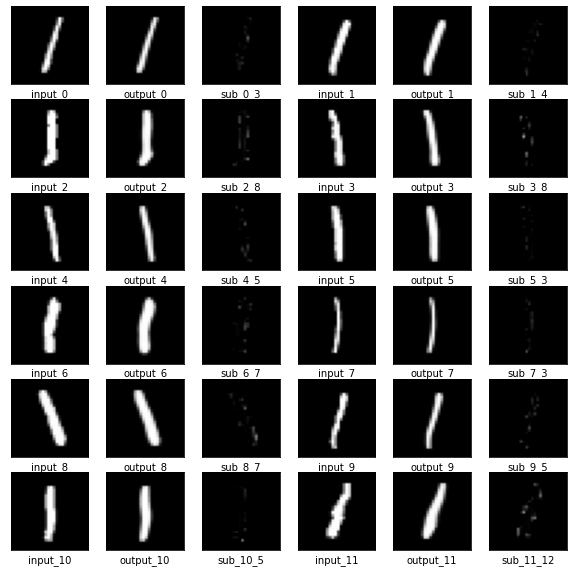

In [ ]:
import copy

def plot_input_output_sub_imgs(input_imgs):
    plt.figure(figsize=(10,10))
    plt_idx = 1
    for i in range(36):
        if plt_idx > 36:
            break
        input_img = input_imgs[i]
        output_img = model.predict(np.expand_dims(input_img, axis=[-1,0]))
        output_img = np.squeeze(output_img)
        sub_img = input_img - output_img
        plt.subplot(6,6,plt_idx)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(np.squeeze(input_imgs[i]), cmap="gray", vmin=0, vmax=1)
        plt.xlabel("input_{}".format(i))


        plt.subplot(6,6,plt_idx+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(output_img, cmap="gray", vmin=0, vmax=1)
        plt.xlabel("output_{}".format(i))

        plt.subplot(6,6,plt_idx+2)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        sum_sub = int(np.sum(np.abs(sub_img)))
        plt.imshow(sub_img, cmap="gray", vmin=0, vmax=1)
        plt.xlabel("sub_{}_{}".format(i, sum_sub))

        plt_idx+=3

    plt.show()

plot_input_output_sub_imgs(x_normal_test)

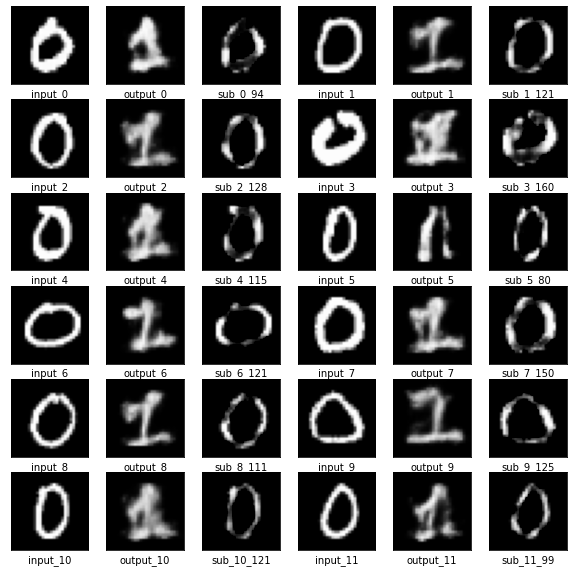

In [ ]:
plot_input_output_sub_imgs(x_abnormal_test)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


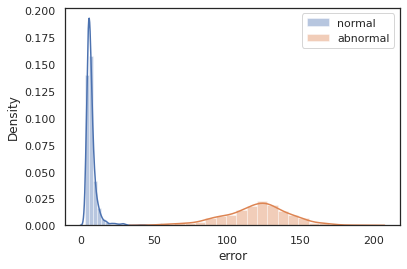

In [ ]:
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

def get_errors(input_imgs):
    output_img = model.predict(input_imgs)
    output_imgs = np.squeeze(output_img)
    sub_imgs = np.abs(input_imgs-output_imgs)
    errors = np.sum(sub_imgs, axis=(1,2))
    return errors

x_normal_errors = get_errors(x_normal_test) 
x_abnormal_errors = get_errors(x_abnormal_test) 
ax=sns.distplot(x_normal_errors,bins=20, label="normal")
sns.distplot(x_abnormal_errors,ax=ax,bins=20, label="abnormal")
ax.set_xlabel("error")
plt.legend()